In [1]:
#pip install requests scipy

In [2]:
!pip uninstall -y transformers
!pip install transformers==4.44.0

Found existing installation: transformers 4.44.0
Uninstalling transformers-4.44.0:
  Successfully uninstalled transformers-4.44.0
  Using cached transformers-4.44.0-py3-none-any.whl.metadata (43 kB)
Using cached transformers-4.44.0-py3-none-any.whl (9.5 MB)


In [3]:
import numpy as np
import pandas as pd
import os
import requests

import zipfile
import glob
from scipy.io import loadmat # To read .mat files

import scipy.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
from urllib3.exceptions import InsecureRequestWarning

import accelerate
import torch
import transformers
from datasets import load_dataset, Dataset, load_from_disk, concatenate_datasets, Features, Value, Sequence, ClassLabel
import datasets

from torch.utils.tensorboard import SummaryWriter
from transformers.integrations import TensorBoardCallback

from google.colab import files
from google.colab import drive

from torch import nn
from torch.nn import functional as F
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from torch.nn.modules.loss import CrossEntropyLoss

# Others
from IPython.core.debugger import set_trace
from pathlib import Path

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

# Dataset preprocessing

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
zip_path = '/content/drive/MyDrive/CWRUDataset.zip'
extract_dir = 'extracted_mat_files/'

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


In [6]:
!ls '/content/extracted_mat_files/CWRU Dataset/Data/12k_FE'
!ls '/content/extracted_mat_files/CWRU Dataset/Data/48k_DE'
!ls '/content/extracted_mat_files/CWRU Dataset/Data/12k_DE'
!ls '/content/extracted_mat_files/CWRU Dataset/Data/Normal'



B007_0.mat  B021_1.mat	 IR014_2.mat	 OR007@12_3.mat  OR014@3_0.mat
B007_1.mat  B021_2.mat	 IR014_3.mat	 OR007@3_0.mat	 OR014@3_1.mat
B007_2.mat  B021_3.mat	 IR021_0.mat	 OR007@3_1.mat	 OR014@3_2.mat
B007_3.mat  IR007_0.mat  IR021_1.mat	 OR007@3_2.mat	 OR014@3_3.mat
B014_0.mat  IR007_1.mat  IR021_2.mat	 OR007@3_3.mat	 OR014@6_0.mat
B014_1.mat  IR007_2.mat  IR021_3.mat	 OR007@6_0.mat	 OR021@3_1.mat
B014_2.mat  IR007_3.mat  OR007@12_0.mat  OR007@6_1.mat	 OR021@3_2.mat
B014_3.mat  IR014_0.mat  OR007@12_1.mat  OR007@6_2.mat	 OR021@3_3.mat
B021_0.mat  IR014_1.mat  OR007@12_2.mat  OR007@6_3.mat	 OR021@6_0.mat
B007_0.mat  B014_0.mat	B021_0.mat  IR007_0.mat  IR014_0.mat  IR021_0.mat
B007_1.mat  B014_1.mat	B021_1.mat  IR007_1.mat  IR014_1.mat  IR021_1.mat
B007_2.mat  B014_2.mat	B021_2.mat  IR007_2.mat  IR014_2.mat  IR021_2.mat
B007_3.mat  B014_3.mat	B021_3.mat  IR007_3.mat  IR014_3.mat  IR021_3.mat
B007_0.mat  B028_0.mat	 IR021_0.mat	 OR007@3_0.mat	OR021@12_0.mat
B007_1.mat  B028_1.mat	 IR021_1.

X → MATLAB variable prefix (usually can be ignored).

A → Fault location/type:

1 → Inner race fault

2 → Ball fault

3 → Outer race fault

0 → Healthy bearing (sometimes 0 is used in some files)

BC → Fault size in thousandths of an inch (mil):

07 → 0.007 inch

14 → 0.014 inch

21 → 0.021 inch

28 → 0.028 inch

DE / FE → Sensor location:

DE → Drive End

FE → Fan End

time → Indicates time-domain signal

In [7]:
mat_data = loadmat('/content/extracted_mat_files/CWRU Dataset/Data/48k_DE/B007_0.mat')
mat_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Mon Jan 31 15:29:05 2000',
 '__version__': '1.0',
 '__globals__': [],
 'X122_DE_time': array([[-0.111192  ],
        [-0.08302892],
        [-0.04234892],
        ...,
        [ 0.02586831],
        [-0.02837169],
        [-0.06759138]]),
 'X122_FE_time': array([[-0.09512545],
        [-0.07211455],
        [-0.02609273],
        ...,
        [ 0.15409091],
        [ 0.07642909],
        [-0.01006727]]),
 'X122RPM': array([[1796]], dtype=uint16)}

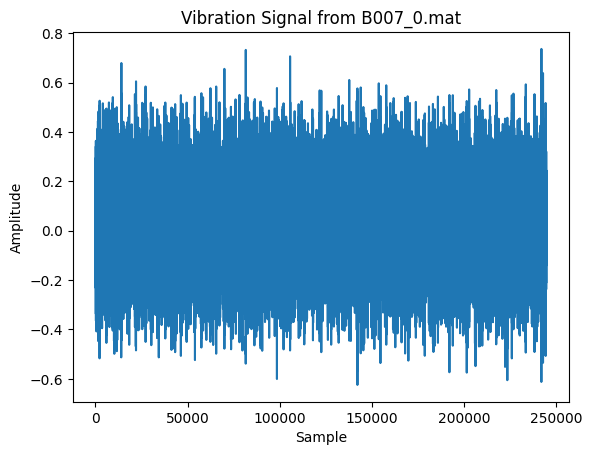

In [8]:
import matplotlib.pyplot as plt

plt.plot(mat_data['X122_DE_time'].squeeze())
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Vibration Signal from B007_0.mat')
plt.show()


In [9]:
import re

#PB DROP WHEN 2D + IMBALANCED DATA NORMAL + p9 problem

def extract_data_from_mat(file_path, key=None):
    mat_data = loadmat(file_path)
    # Remove metadata keys that start with "__"
    mat_keys = [k for k in mat_data.keys() if not k.startswith("__")]

    if key is None:
        # Pick first array-like key
        key = mat_keys[0]

    data = mat_data[key]

    # Convert to torch tensor
    if data.ndim == 1:
        data = data.reshape(-1, 1)
    else:
        data = data[:, 0].reshape(-1, 1)
        data = data.reshape(-1, 1)


    if os.path.basename(file_path).startswith('B'):
      label=('Ball')
    elif os.path.basename(file_path).startswith('IR'):
      label=('Inner race')
    elif os.path.basename(file_path).startswith('OR'):
      label=('Outer race')
    elif os.path.basename(file_path).startswith('Normal'):
      label=('Normal')



    return data, label


In [10]:
def load_folder(folder_path, key=None):
    all_data = []
    labels=[]
    if os.path.basename(folder_path).startswith('12'):
      freq=12
    else:
      freq=48
    for filename in os.listdir(folder_path):
        if filename.endswith(".mat"):
            file_path = os.path.join(folder_path, filename)
            data,label = extract_data_from_mat(file_path, key=key)
            all_data.append(data)
            labels.append(label)

    return all_data,labels,freq


In [11]:
file_paths = ['/content/extracted_mat_files/CWRU Dataset/Data/48k_DE/', '/content/extracted_mat_files/CWRU Dataset/Data/12k_DE/', '/content/extracted_mat_files/CWRU Dataset/Data/12k_FE/','/content/extracted_mat_files/CWRU Dataset/Data/Normal/']
all_data = []
all_labels = []
freq = []
for folder in file_paths:
    data,labels,frequence = load_folder(folder)
    if all_data:
      all_data=all_data+data
      all_labels=all_labels+labels
      freq=freq+[frequence] * len(all_labels)

    else:
      all_data=data
      all_labels=labels
      freq=[frequence] * len(all_labels)

#torch.save(full_dataset,'/content/drive/MyDrive/Labproject/full_dataset.pt')


In [12]:
print(all_data[0:5], len(all_labels))

[array([[-0.05277969],
       [-0.00709292],
       [ 0.05778646],
       ...,
       [-0.15354092],
       [-0.10096985],
       [-0.04547815]]), array([[ 0.001252  ],
       [-0.02837867],
       [-0.05634   ],
       ...,
       [ 0.20115467],
       [ 0.182792  ],
       [ 0.15942133]]), array([[ 0.09992677],
       [ 0.14164985],
       [ 0.17836615],
       ...,
       [-0.08490646],
       [-0.05945538],
       [-0.00625846]]), array([[ 0.03984554],
       [ 0.08970462],
       [ 0.13664308],
       ...,
       [ 0.00897046],
       [-0.01001354],
       [-0.01668923]]), array([[-0.20360862],
       [-0.29539938],
       [-0.35506338],
       ...,
       [ 0.00834462],
       [ 0.03880246],
       [ 0.07301538]])] 132


Divide in windows of 2048 pts

In [13]:
max_length=2048
step=512
input_chunk=[]
target_chunk=[]
final_freq=[]
for i in range(0,len(all_labels)):
  for j in range(0,len(all_data[i])-max_length,step):
    if len(all_data[i][j:j+max_length])>0:
      input_chunk.append(all_data[i][j:j+max_length])
      target_chunk.append(all_labels[i])
      final_freq.append(freq[i])

In [14]:
print(len(input_chunk[0]))

2048


In [15]:
print(len(target_chunk))

45564


In [16]:
input_chunk=np.array(input_chunk)
final_freq=np.array(final_freq)

In [17]:
def calculate_features(x, fs):

    N = len(x)
    # Fourier transform
    fft_vals = np.fft.fft(x)
    fft_freq = np.fft.fftfreq(N, 1/fs)
    # Use only the positive frequency components to avoid redundancy
    K = N // 2
    s = np.abs(fft_vals[:K])
    f = fft_freq[:K]

    # Time-Domain Features
    p1 = np.mean(x)
    p2 = np.std(x, ddof=1) # ddof=1 for sample standard deviation
    p3 = (np.mean(np.sqrt(np.abs(x))))**2
    p4 = np.mean(np.abs(x))
    p5 = np.max(np.abs(x))
    p6 = np.mean(x**3) # This is the third moment, not standardized skewness.
    p7 = np.mean(x**4) # This is the fourth moment, not standardized kurtosis.
    p8 = np.mean(x**2) # This is the mean square value.
    p9 = p7 / np.abs(p6) #WEIRD
    p10 = p5 / p2
    p11 = p2 / p4
    p12 = p5 / p4
    p13 = np.mean(s)
    p14 = np.var(s, ddof=1) # Sample variance of the spectrum
    p15 = (1 / (K * p14**(3/2))) * np.sum((s - p13)**3) # Spectral skewness
    p16 = (1 / (K * p14**2)) * np.sum((s - p13)**4)     # Spectral kurtosis
    p17 = np.sum(f * s) / np.sum(s) # Gravity frequency / Mean Frequency
    p18 = np.sqrt(np.sum(((f - p17)**2) * s) / K*np.sum(s))
    p19 = np.sqrt(np.sum((f**2) * s) / np.sum(s)) # RMS Frequency
    p20 = np.sqrt(np.sum(f**4 * s) / np.sum(f**2 * s)) # Average frequency
    p21 = np.sum(f**2 * s) / np.sqrt(np.sum(s) / np.sum(f**4 * s))
    p22 = p18 / p17 # Variation parameter
    p23 = np.sum((f - p17)**3 * s) / (K * p18**3) # Spectral third moment
    p24 = np.sum((f - p17)**4 * s) / (K * p18**4) # Spectral fourth moment

    feat=[p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24]
    return feat

In [18]:
chunk=2500
Features1=[]
for i in range(0,len(input_chunk)):
  Features1.append(calculate_features(input_chunk[i],final_freq[i]))
  #print(i)

In [19]:
len(Features1)

45564

In [20]:
def prompting(features=Features1):
  t='time'
  f='frequency'
  feat=[]
  for feature in features:
    prompt0= "You are a bearing fault diagnosis expert. Based on the following features, you need to conduct fault diagnosis:"
    prompt1=f' The mean value of the vibration signal in the {t} domain is {feature[0]}.'
    prompt2=f' The standard deviation of the vibration signal in the {t} domain is {feature[1]}.'
    prompt3=f' The square root amplitude of the vibration signal in the {t} domain is {feature[2]}.'
    prompt4=f' The absolute mean value of the vibration signal in the {t} domain is {feature[3]}.'
    prompt5=f' The peak value of the vibration signal in the {t} domain is {feature[4]}.'
    prompt6=f' The skewness of the vibration signal in the {t} domain is {feature[5]}.'
    prompt7=f' The kurtosis of the vibration signal in the {t} domain is {feature[6]}.'
    prompt8=f' The variance of the vibration signal in the {t} domain is {feature[7]}.'
    prompt9=f' The kurtosis index of the vibration signal in the {t} domain is {feature[8]}.'
    prompt10=f' The peak index of the vibration signal in the {t} domain is {feature[9]}.'
    prompt11=f' The waveform index of the vibration signal in the {t} domain is {feature[10]}.'
    prompt12=f' The pulse index of the vibration signal in the {t} domain is {feature[11]}.'
    prompt13=f' The frequency mean value of the vibration signal in the {f} domain is {feature[12]}.'
    prompt14=f' The frequency variance of the vibration signal in the {f} domain is {feature[13]}.'
    prompt15=f' The frequency skewness of the vibration signal in the {f} domain is {feature[14]}.'
    prompt16=f' The frequency kurtosis of the vibration signal in the {f} domain is {feature[15]}.'
    prompt17=f' The gravity frequency of the vibration signal in the {f} domain is {feature[16]}.'
    prompt18=f' The frequency standard deviation of the vibration signal in the {f} domain is {feature[17]}.'
    prompt19=f' The frequency root mean square of the vibration signal in the {f} domain is {feature[18]}.'
    prompt20=f' The average frequency of the vibration signal in the {f} domain is {feature[19]}.'
    prompt21=f' The regularity degree of the vibration signal in the {f} domain is {feature[20]}.'
    prompt22=f' The variation parameter of the vibration signal in the {f} domain is {feature[21]}.'
    prompt23=f' The eighth-order moment of the vibration signal in the {f} domain is {feature[22]}.'
    prompt24=f' The sixteenth order moment of the vibration signal in the {f} domain is {feature[23]}.'

    feat.append(prompt0+prompt1+prompt2+prompt3+prompt4+prompt5+prompt6+prompt7+prompt8+prompt9+prompt10+prompt11+prompt12+prompt13+prompt14+prompt15+prompt16+prompt17+prompt18+prompt19+prompt20+prompt21+prompt22+prompt23+prompt24)
  return feat


In [21]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

numeric_labels = encoder.fit_transform(target_chunk)

print(f"Classes (mapping): {encoder.classes_}")

Classes (mapping): ['Ball' 'Inner race' 'Normal' 'Outer race']


In [22]:
X=prompting()
y=numeric_labels

In [23]:
print(len(X),len(y))

45564 45564


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,    # 20% for testing
    random_state=42,  # for reproducibility
    stratify=y
)

In [25]:
import torch
torch.cuda.empty_cache()


In [26]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "THUDM/chatglm2-6b"
num_classes = 4

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

# Load model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_classes,
    trust_remote_code=True
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
A new version of the following files was downloaded from https://huggingface.co/THUDM/chatglm2-6b:
- quantization.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Some weights of ChatGLMForSequenceClassification were not initialized from the model checkpoint at THUDM/chatglm2-6b and are newly initialized: ['classifier_head.bias', 'classifier_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DataCollatorWithPadding
from transformers import Trainer, TrainingArguments

from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)


class CustomDataset(Dataset):
    def __init__(self, features, labels, tokenizer=tokenizer, max_length=2048):
        assert len(features) == len(labels)
        self.features = features
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.features[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors=None
          )
        # Manual padding
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']


        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

batch_size = 32

# Training DataLoader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,  # Shuffles data for every epoch
    drop_last=True,
    collate_fn=data_collator
)

# Testing DataLoader
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator
)


In [28]:
def feature_to_text(features):
    # Convert a numeric feature vector into a simple string representation
    return " ".join(map(str, features))

train_texts = [feature_to_text(f) for f in X_train]
test_texts = [feature_to_text(f) for f in X_test]

train_dataset = CustomDataset(train_texts, y_train)
test_dataset = CustomDataset(test_texts, y_test)


In [29]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    task_type="SEQ_CLS",
    r=8,  # Rank of the update matrices (a key LoRA parameter)
    lora_alpha=32, # LoRA scaling factor
    target_modules=["query_key_value"], # Apply LoRA to the attention layers
    lora_dropout=0.1,
)

# Create the PEFT model by wrapping the base model with the LoRA config
peft_model = get_peft_model(model, lora_config)

# You can print the trainable parameters to see the huge reduction
peft_model.print_trainable_parameters()

trainable params: 1,949,696 || all params: 6,245,550,084 || trainable%: 0.0312


In [30]:
import torch.nn as nn

for name, module in peft_model.named_modules():
    if "classifier_head" in name:
        def _init_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

        module.apply(_init_weights)
        print("Reinitialization complete.")

Reinitialization complete.


In [31]:
import torch

print("\nVerifying weights are now valid...")
# Check parameters specifically in the classifier_head
for n, p in peft_model.named_parameters():
    if "classifier_head" in n:
        has_nan = torch.isnan(p).any().item()
        print(f"Parameter '{n}' has NaN: {has_nan}")


Verifying weights are now valid...
Parameter 'base_model.model.classifier_head.weight' has NaN: False
Parameter 'base_model.model.classifier_head.bias' has NaN: False


In [32]:
import types

# Patch the forward of the PEFT model to ignore unsupported args
def patched_forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
    return self.base_model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        labels=labels
    )

peft_model.forward = types.MethodType(patched_forward, peft_model)


In [33]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/results",          # Directory to save results
    per_device_train_batch_size=1,  # Number of samples per batch
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=8,
    num_train_epochs=1,              # Number of times to go through the dataset
    learning_rate=5e-6,              # The speed at which the model learns
    logging_steps=10,                # How often to log training progress
    save_steps=50,                   # How often to save a checkpoint
    save_total_limit=3,
    remove_unused_columns=False,  # Important for custom datasets
    fp16=True)

In [34]:
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # The model outputs logits, so we take the argmax to get the predicted class
    preds = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

In [35]:
batch = next(iter(train_loader))
print(batch['input_ids'].shape)   # [batch_size, seq_len]
print(batch['labels'].shape)      # [batch_size]


torch.Size([32, 2048])
torch.Size([32])


In [36]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()


In [37]:
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


# Start the fine-tuning
#trainer.train()
trainer.train(resume_from_checkpoint=True)


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ilar-alberto77 (ilar-alberto77-centralesup-lec) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


TrainOutput(global_step=4556, training_loss=0.0, metrics={'train_runtime': 468.4167, 'train_samples_per_second': 77.817, 'train_steps_per_second': 9.726, 'total_flos': 2.6779276610450227e+18, 'train_loss': 0.0, 'epoch': 0.9999176977312008})

In [38]:
peft_model.save_pretrained("/content/drive/MyDrive/lora-adapters")

In [39]:
# Run the evaluation
evaluation_results = trainer.evaluate()

print(evaluation_results)

OutOfMemoryError: CUDA out of memory. Tried to allocate 608.00 MiB. GPU 0 has a total capacity of 79.32 GiB of which 483.88 MiB is free. Process 105546 has 78.84 GiB memory in use. Of the allocated memory 77.59 GiB is allocated by PyTorch, and 764.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Jialing richard, look at pipeline

gitlab-research.centralesupelec.fr/mesocentre-public
pytorch on ruche
pytorch andrew and colorado + revoir tf
pytorch book llm from scratch

run his pipeline with CNN with the two datasets we had before
if Qs, ask jialing directly or in teams channel
tutorial solal
tutorial moesocentre ppt to follow

since it's less work, work on pytorch, huggingface, transformers, coursera videos and labs apply to interviews and train in coding

lightning ai


look at the pipeline and look how to put my model in the pipeline


look at the slides from Adnane